# BME-Crete Master Thesis (Results analysis)
### by **Stylianos Zafeiris**

### Imports and necessary variable declarations

In [1]:
from pathlib import Path
import pandas as pd
import json
from matplotlib import pyplot as plt

Useful functions

In [2]:
def printMaxScore(scoreName, dataset):
    bestScore = dataset.loc[dataset[scoreName].idxmax()]
    print(f"{'='*11} Max {scoreName} {'='*11}\n{bestScore}\n")

#### Make sure that all results are extracted

In [3]:
# ! python .\extract_results.py

#### Declare datasets' results paths and load them

Read datasets and load them. Then merge them into one dataframe and sort it.

In [4]:
origDatasetPath = Path('./data/results/original_results.csv')
origDataset = pd.read_csv(origDatasetPath.absolute())

origNormDatasetPath = Path('./data/results/original_norm_results.csv')
origNormDataset = pd.read_csv(origNormDatasetPath.absolute())

n4DatasetPath = Path('./data/results/n4_results.csv')
n4Dataset = pd.read_csv(n4DatasetPath.absolute())

n4NormDatasetPath = Path('./data/results/n4_norm_results.csv')
n4NormDataset = pd.read_csv(n4NormDatasetPath.absolute())

fatDatasetPath = Path('./data/results/fat_results.csv')
fatDataset = pd.read_csv(fatDatasetPath.absolute())

muscleDatasetPath = Path('./data/results/muscle_results.csv')
muscleDataset = pd.read_csv(muscleDatasetPath.absolute())


merged = pd.concat([origDataset, origNormDataset, n4Dataset, n4NormDataset, fatDataset, muscleDataset], ignore_index=True)
merged.sort_values(by=['balanced_accuracy_score', 'roc_auc_score', 'datasetName', 'featureSelectionMethodName', 'classifierName'])

# Add extra columns
merged['fullDatasetName'] = merged.apply(lambda x: f"{x['datasetName']}{'_norm' if x['isNormalized'] else ''}", axis=1, )

merged['sensitivity'] = merged.apply(lambda x: x["TP"] / (x["TP"] + x["FN"]), axis=1)
merged['speficity'] = merged.apply(lambda x: x["TN"] / (x["TN"] + x["FP"]), axis=1)

# Drop rows that contain univariate ITMO data
merged = merged.drop(merged[merged["featureSelectionMethodName"].str.contains("-itmo")].index)
merged

,featureSelectionMethodName,classifierName,datasetName,isNormalized,selectedFeaturesNo,selectedThreshold,accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,cohen_kappa_score,TN,FP,FN,TP,fullDatasetName,sensitivity,speficity
0,boruta,gnb,original,False,67,0.0,0.566667,0.558644,0.493506,0.475000,0.513514,0.558644,0.115869,32,21,18,19,original,0.513514,0.603774
1,boruta,knn,original,False,79,0.0,0.600000,0.533333,0.357143,0.384615,0.333333,0.533333,0.068966,44,16,20,10,original,0.333333,0.733333
2,boruta,rf,original,False,178,0.0,0.544444,0.528571,0.438356,0.421053,0.457143,0.528571,0.056266,33,22,19,16,original,0.457143,0.600000
3,boruta,svm-linear,original,False,130,0.0,0.533333,0.509259,0.400000,0.411765,0.388889,0.509259,0.018692,34,20,22,14,original,0.388889,0.629630
4,boruta,svm-rbf,original,False,61,0.0,0.644444,0.581408,0.407407,0.550000,0.323529,0.581408,0.177143,47,9,23,11,original,0.323529,0.839286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,surf,knn,muscle,False,78,0.0,0.633333,0.587963,0.440678,0.565217,0.361111,0.587963,0.187192,44,10,23,13,muscle,0.361111,0.814815
534,surf,rf,muscle,False,8,0.0,0.544444,0.513664,0.369231,0.444444,0.315789,0.513664,0.028436,37,15,26,12,muscle,0.315789,0.711538
535,surf,svm-linear,muscle,False,28,0.0,0.588889,0.516318,0.177778,0.500000,0.108108,0.516318,0.037016,49,4,33,4,muscle,0.108108,0.924528
536,surf,svm-rbf,muscle,False,3,0.0,0.644444,0.522143,0.200000,0.444444,0.129032,0.522143,0.053254,54,5,27,4,muscle,0.129032,0.915254


Count dataset sample size

In [5]:
merged.groupby(by='fullDatasetName')['fullDatasetName'].aggregate(['count'])

,count
fullDatasetName,
fat,78
muscle,78
n4,78
n4_norm,78
original,78
original_norm,76


In [6]:
def convertClassifierName(name):
    if 'svm' in name:
        splt = name.split('-')
        ret = f'{splt[0].upper()} ({splt[1].title()} kernel)'
    elif name == 'gnb':
        ret = 'Gausian Naive Bayes'
    elif name == 'rf':
        ret = 'Random Forest'
    elif name == 'knn':
        ret = 'k-Nearest Neighbors'
    elif name == 'xgb':
        ret = 'XGBoost'
    else:
        return name.title()

    return ret

def convertFsMethodName(name):
    if name == 'boruta':
        return 'Boruta'
    elif 'spearman' in name or 'pearson' in name:
        return f"{name.title()} coefficient-based\nfeature selection"
    elif 'star' in name:
        return name.replace('star', '*').title() 
    elif 'urf' in name:
        return name.title()
    elif 'relieff' == name:
        return 'ReliefF'
    elif 'mrmr' == name:
        return 'mRMR'
    
    return name.upper()

merged_beatify = merged.copy()
merged_beatify['fullDatasetName'] = merged_beatify['fullDatasetName'].apply(lambda x: x.replace('_', ' ').title().replace('Norm', '\n(Normalized)'))
merged_beatify['featureSelectionMethodName'] = merged_beatify['featureSelectionMethodName'].apply(lambda x: convertFsMethodName(x))
merged_beatify['classifierName'] = merged_beatify['classifierName'].apply(lambda x: convertClassifierName(x))
merged_beatify

,featureSelectionMethodName,classifierName,datasetName,isNormalized,selectedFeaturesNo,selectedThreshold,accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,cohen_kappa_score,TN,FP,FN,TP,fullDatasetName,sensitivity,speficity
0,Boruta,Gausian Naive Bayes,original,False,67,0.0,0.566667,0.558644,0.493506,0.475000,0.513514,0.558644,0.115869,32,21,18,19,Original,0.513514,0.603774
1,Boruta,k-Nearest Neighbors,original,False,79,0.0,0.600000,0.533333,0.357143,0.384615,0.333333,0.533333,0.068966,44,16,20,10,Original,0.333333,0.733333
2,Boruta,Random Forest,original,False,178,0.0,0.544444,0.528571,0.438356,0.421053,0.457143,0.528571,0.056266,33,22,19,16,Original,0.457143,0.600000
3,Boruta,SVM (Linear kernel),original,False,130,0.0,0.533333,0.509259,0.400000,0.411765,0.388889,0.509259,0.018692,34,20,22,14,Original,0.388889,0.629630
4,Boruta,SVM (Rbf kernel),original,False,61,0.0,0.644444,0.581408,0.407407,0.550000,0.323529,0.581408,0.177143,47,9,23,11,Original,0.323529,0.839286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,Surf,k-Nearest Neighbors,muscle,False,78,0.0,0.633333,0.587963,0.440678,0.565217,0.361111,0.587963,0.187192,44,10,23,13,Muscle,0.361111,0.814815
534,Surf,Random Forest,muscle,False,8,0.0,0.544444,0.513664,0.369231,0.444444,0.315789,0.513664,0.028436,37,15,26,12,Muscle,0.315789,0.711538
535,Surf,SVM (Linear kernel),muscle,False,28,0.0,0.588889,0.516318,0.177778,0.500000,0.108108,0.516318,0.037016,49,4,33,4,Muscle,0.108108,0.924528
536,Surf,SVM (Rbf kernel),muscle,False,3,0.0,0.644444,0.522143,0.200000,0.444444,0.129032,0.522143,0.053254,54,5,27,4,Muscle,0.129032,0.915254


### Main analysis

#### Create balanced accuracy boxplots

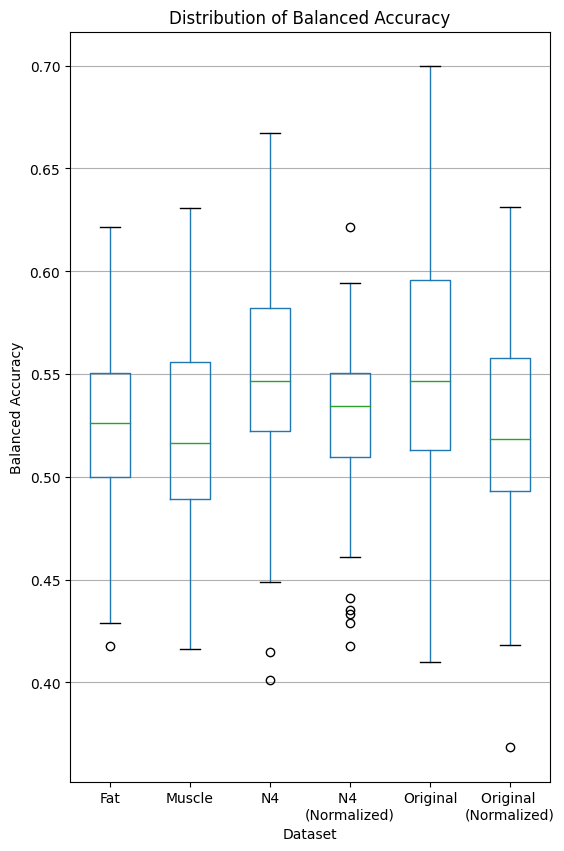

In [7]:
# Show boxplot for balanced acc
merged_bplt = merged_beatify.boxplot(
    column=[
        'balanced_accuracy_score',
    ],
    by= ['fullDatasetName'],
    rot=0, figsize=(6, 10) )
merged_bplt.plot()
plt.title('Distribution of Balanced Accuracy')
plt.suptitle('')
plt.xlabel('Dataset')
plt.ylabel('Balanced Accuracy')
plt.grid(axis='x')
plt.show()

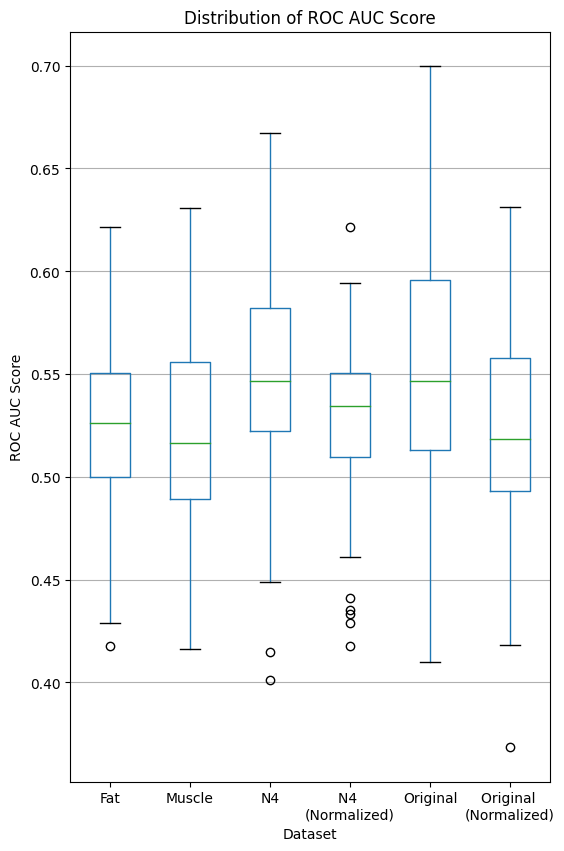

In [8]:
# Show boxplot for balanced acc
merged_bplt = merged_beatify.boxplot(
    column=[
        'roc_auc_score',
    ],
    by= ['fullDatasetName'],
    rot=0, figsize=(6, 10) )
merged_bplt.plot()
plt.title('Distribution of ROC AUC Score')
plt.suptitle('')
plt.xlabel('Dataset')
plt.ylabel('ROC AUC Score')
plt.grid(axis='x')
plt.show()

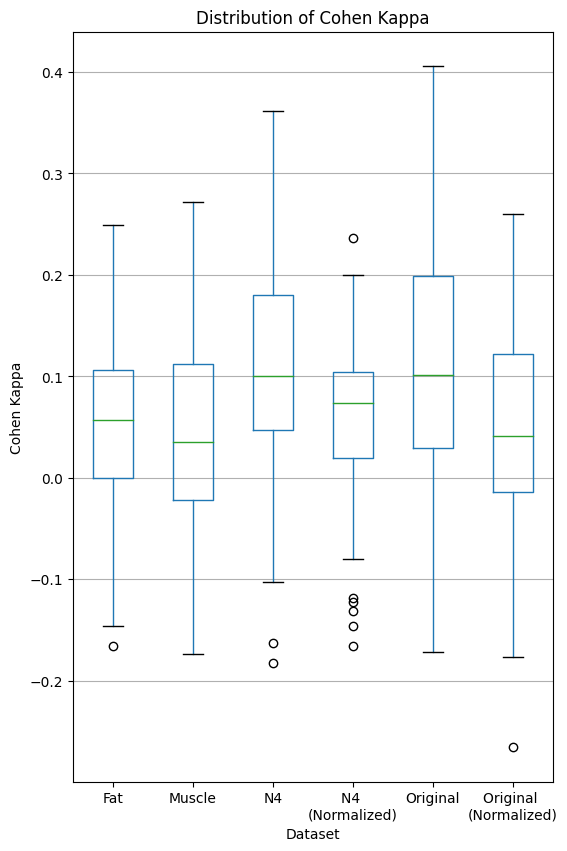

In [9]:
# Show boxplot for balanced acc
merged_bplt = merged_beatify.boxplot(
    column=[
        'cohen_kappa_score',
    ],
    by= ['fullDatasetName'],
    rot=0, figsize=(6, 10), )
merged_bplt.plot()
plt.title('Distribution of Cohen Kappa')
plt.suptitle('')
plt.xlabel('Dataset')
plt.ylabel('Cohen Kappa')
plt.grid(axis='x')
plt.show()

Print max scores

In [10]:
printMaxScore('balanced_accuracy_score', origDataset)


=========== Max balanced_accuracy_score ===========
featureSelectionMethodName     pearson
classifierName                     xgb
datasetName                   original
isNormalized                     False
selectedFeaturesNo                 175
selectedThreshold                 0.85
accuracy_score                0.722222
balanced_accuracy_score            0.7
f1_score                      0.626866
precision_score                0.65625
recall_score                       0.6
roc_auc_score                      0.7
cohen_kappa_score             0.406332
TN                                  44
FP                                  11
FN                                  14
TP                                  21
Name: 59, dtype: object



In [11]:
printMaxScore('balanced_accuracy_score', origNormDataset)

=========== Max balanced_accuracy_score ===========
featureSelectionMethodName       pearson
classifierName                svm-linear
datasetName                     original
isNormalized                        True
selectedFeaturesNo                   143
selectedThreshold                    0.7
accuracy_score                  0.644444
balanced_accuracy_score         0.631169
f1_score                        0.555556
precision_score                 0.540541
recall_score                    0.571429
roc_auc_score                   0.631169
cohen_kappa_score                0.25964
TN                                    38
FP                                    17
FN                                    15
TP                                    20
Name: 55, dtype: object



In [12]:
printMaxScore('balanced_accuracy_score', n4Dataset)

=========== Max balanced_accuracy_score ===========
featureSelectionMethodName     relieff
classifierName                     knn
datasetName                         n4
isNormalized                     False
selectedFeaturesNo                  68
selectedThreshold                  0.0
accuracy_score                0.722222
balanced_accuracy_score       0.667017
f1_score                      0.545455
precision_score               0.714286
recall_score                  0.441176
roc_auc_score                 0.667017
cohen_kappa_score             0.361158
TN                                  50
FP                                   6
FN                                  19
TP                                  15
Name: 61, dtype: object



In [13]:
printMaxScore('balanced_accuracy_score', n4NormDataset)

=========== Max balanced_accuracy_score ===========
featureSelectionMethodName        mrmr
classifierName                      rf
datasetName                         n4
isNormalized                      True
selectedFeaturesNo                  23
selectedThreshold                  0.0
accuracy_score                0.644444
balanced_accuracy_score       0.621651
f1_score                      0.515152
precision_score               0.485714
recall_score                  0.548387
roc_auc_score                 0.621651
cohen_kappa_score             0.236074
TN                                  41
FP                                  18
FN                                  14
TP                                  17
Name: 32, dtype: object



In [14]:
printMaxScore('balanced_accuracy_score', fatDataset)

=========== Max balanced_accuracy_score ===========
featureSelectionMethodName        mrmr
classifierName                      rf
datasetName                        fat
isNormalized                     False
selectedFeaturesNo                  23
selectedThreshold                  0.0
accuracy_score                0.644444
balanced_accuracy_score       0.621651
f1_score                      0.515152
precision_score               0.485714
recall_score                  0.548387
roc_auc_score                 0.621651
cohen_kappa_score             0.236074
TN                                  41
FP                                  18
FN                                  14
TP                                  17
Name: 32, dtype: object



In [15]:
printMaxScore('balanced_accuracy_score', muscleDataset)

=========== Max balanced_accuracy_score ===========
featureSelectionMethodName    multisurf
classifierName                  svm-rbf
datasetName                      muscle
isNormalized                      False
selectedFeaturesNo                   18
selectedThreshold                   0.0
accuracy_score                 0.677778
balanced_accuracy_score        0.630927
f1_score                       0.508475
precision_score                0.555556
recall_score                    0.46875
roc_auc_score                  0.630927
cohen_kappa_score              0.271357
TN                                   46
FP                                   12
FN                                   17
TP                                   15
Name: 46, dtype: object



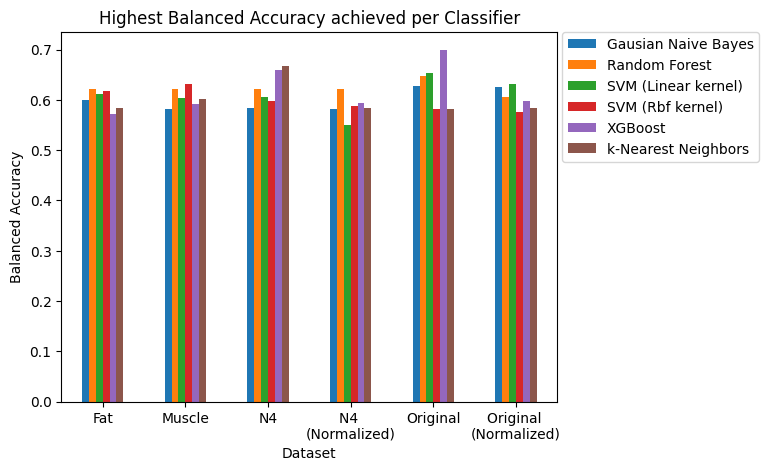

In [16]:
new_merged = merged_beatify.groupby(['fullDatasetName','classifierName'])['balanced_accuracy_score'].max().unstack().plot.bar(rot=0)

plt.xlabel('Dataset')
plt.ylabel('Balanced Accuracy')
plt.title('Highest Balanced Accuracy achieved per Classifier')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

In [17]:
merged.groupby(['fullDatasetName','classifierName'])['balanced_accuracy_score'].max()

fullDatasetName  classifierName
fat              gnb               0.600000
                 knn               0.582866
                 rf                0.621651
                 svm-linear        0.611688
                 svm-rbf           0.616918
                 xgb               0.572673
muscle           gnb               0.581818
                 knn               0.601734
                 rf                0.621651
                 svm-linear        0.603285
                 svm-rbf           0.630927
                 xgb               0.592611
n4               gnb               0.583117
                 knn               0.667017
                 rf                0.620602
                 svm-linear        0.605276
                 svm-rbf           0.597222
                 xgb               0.658338
n4_norm          gnb               0.581818
                 knn               0.583502
                 rf                0.621651
                 svm-linear        0.550649


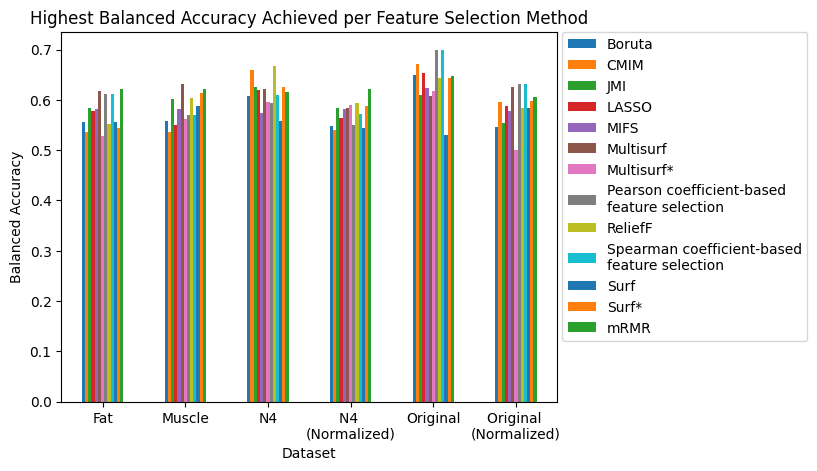

In [18]:
new_merged = merged_beatify.groupby(['fullDatasetName','featureSelectionMethodName'])['balanced_accuracy_score'].max().unstack().plot.bar(rot=0)

plt.xlabel('Dataset')
plt.ylabel('Balanced Accuracy')
plt.title('Highest Balanced Accuracy Achieved per Feature Selection Method')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

#### Get resultrs per classifier

In [19]:
def plotScoreByClassifier(classifierName):
    classfier = merged.loc[merged['classifierName'] == classifierName]
    classfier['fullDatasetName'] = classfier['fullDatasetName'].apply(lambda x: x.replace('_', ' ').title().replace('Norm', '\n(Normalized)'))
    classfier['featureSelectionMethodName'] = classfier['featureSelectionMethodName'].apply(lambda x: convertFsMethodName(x))
    classifierRes = classfier.groupby(['fullDatasetName','featureSelectionMethodName'])['balanced_accuracy_score'].max().unstack()

    ax = classifierRes.plot.bar(figsize=(8, 5), rot=0)
    plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left', borderaxespad=0)
    plt.title(convertClassifierName(classifierName))
    plt.xlabel('Dataset')
    plt.ylabel('Balanced Accuracy')
    ax.set(axisbelow=True)
    plt.grid(axis='y')
    
    path = Path(f'./data/results/plots/per_classifier/')
    path.mkdir(exist_ok=True)        
    plt.savefig(path.joinpath(f'{classifierName}_per_plot.jpeg'), bbox_inches='tight', dpi=300)

def plotScoreByFSMethod(featureSelectionMethodName):
    fsMethod = merged.loc[merged['featureSelectionMethodName'] == featureSelectionMethodName]
    fsMethod['fullDatasetName'] = fsMethod['fullDatasetName'].apply(lambda x: x.replace('_', ' ').title().replace('Norm', '\n(Normalized)'))
    fsMethod['classifierName'] = fsMethod['classifierName'].apply(lambda x: convertClassifierName(x))
    fsMethodRes = fsMethod.groupby(['fullDatasetName','classifierName'])['balanced_accuracy_score'].max().unstack()

    ax = fsMethodRes.plot.bar(figsize=(8, 5), rot=0)
    plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left', borderaxespad=0)
    plt.title(convertFsMethodName(featureSelectionMethodName))
    plt.xlabel('Dataset')
    plt.ylabel('Balanced Accuracy')
    ax.set(axisbelow=True)
    plt.grid(axis='y')
    
    path = Path(f'./data/results/plots/per_fs-method/')
    path.mkdir(exist_ok=True)        
    plt.savefig(path.joinpath(f'{featureSelectionMethodName}_per_plot.jpeg'), bbox_inches='tight', dpi=300)
    
classifiers = merged['classifierName'].unique().tolist()
methods = merged['featureSelectionMethodName'].unique().tolist()

C:\Users\szafeiris\AppData\Local\Temp\ipykernel_75908\2786503442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classfier['fullDatasetName'] = classfier['fullDatasetName'].apply(lambda x: x.replace('_', ' ').title().replace('Norm', '\n(Normalized)'))
C:\Users\szafeiris\AppData\Local\Temp\ipykernel_75908\2786503442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classfier['featureSelectionMethodName'] = classfier['featureSelectionMethodName'].apply(lambda x: convertFsMethodName(x))
C:\Users\szafeiri

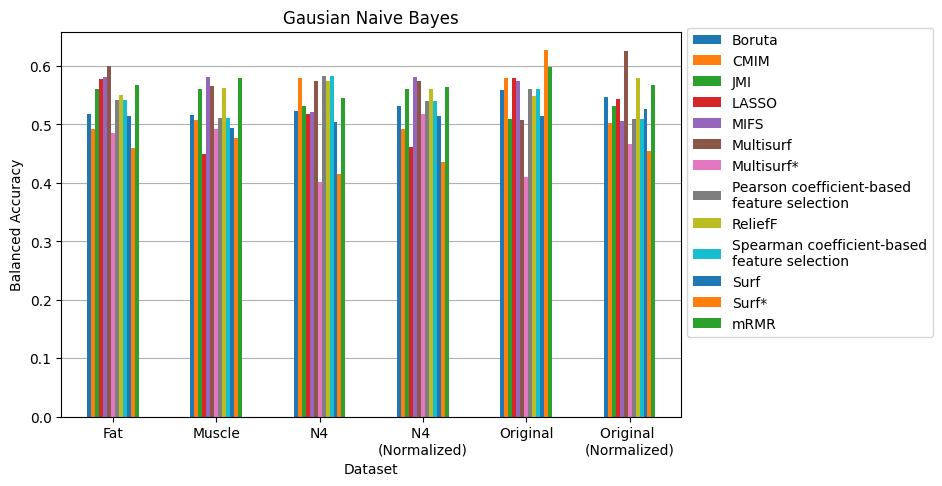

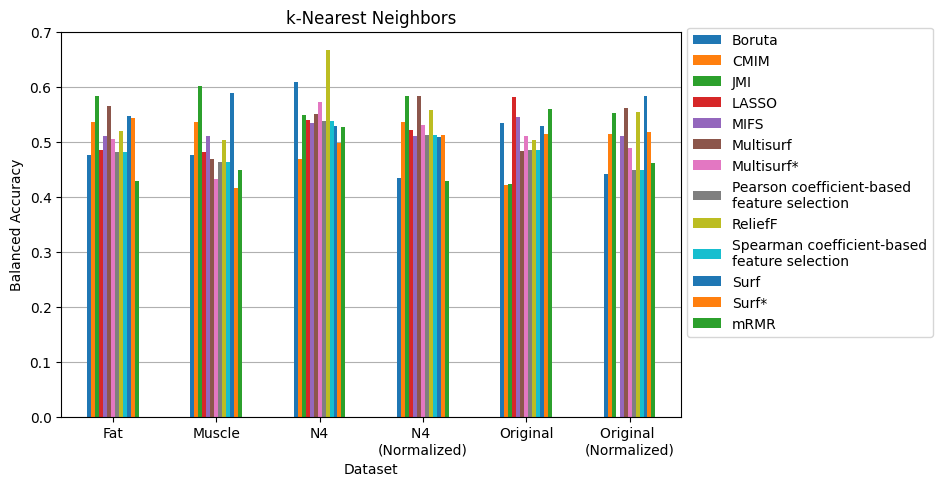

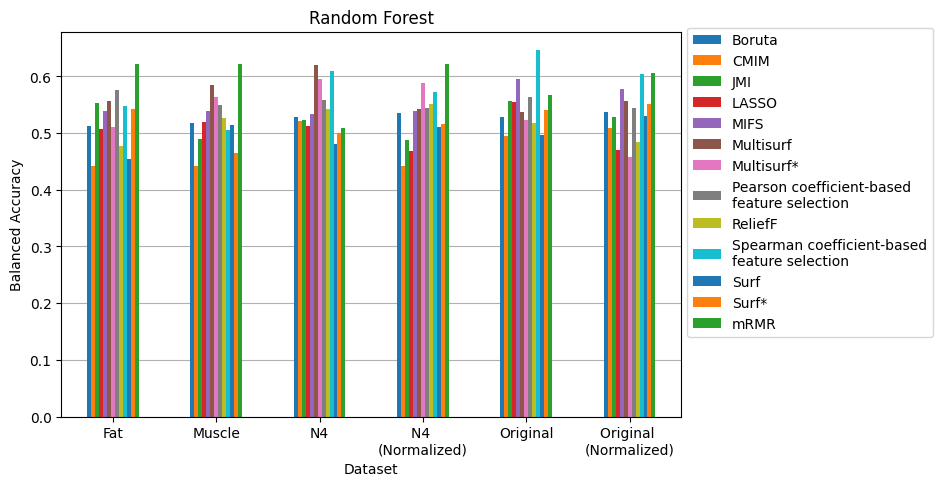

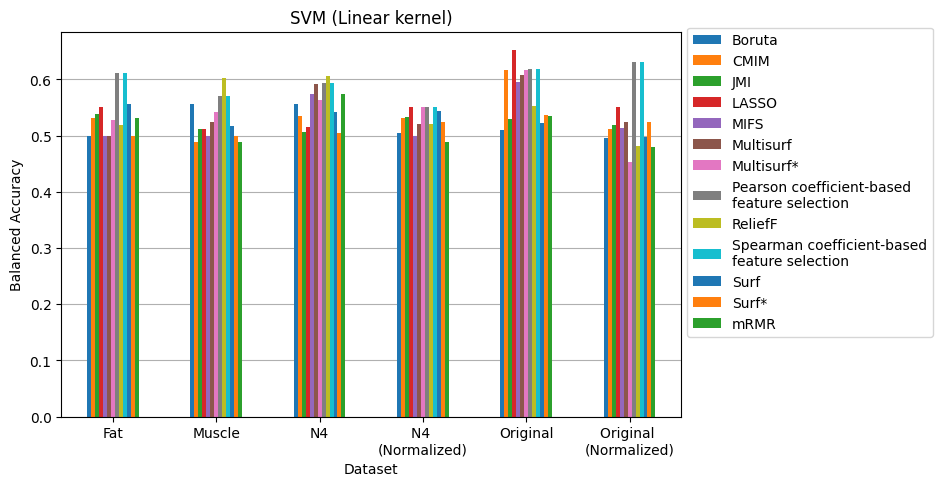

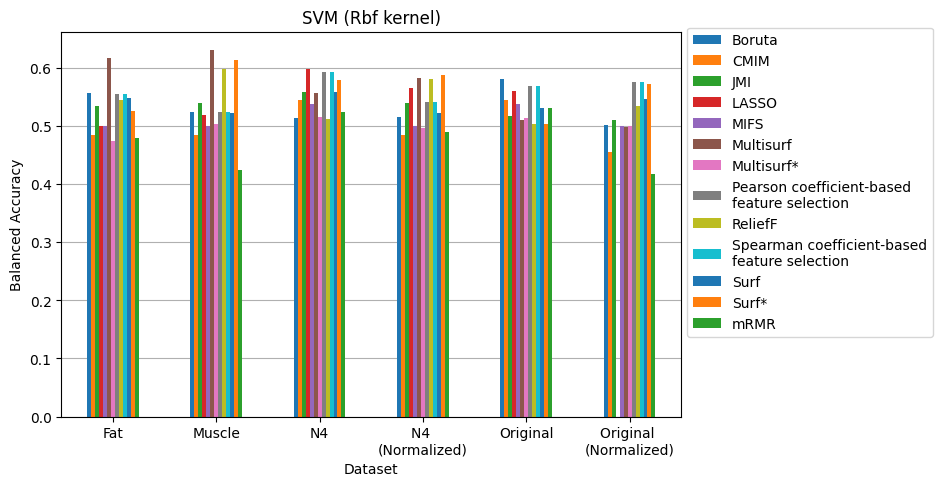

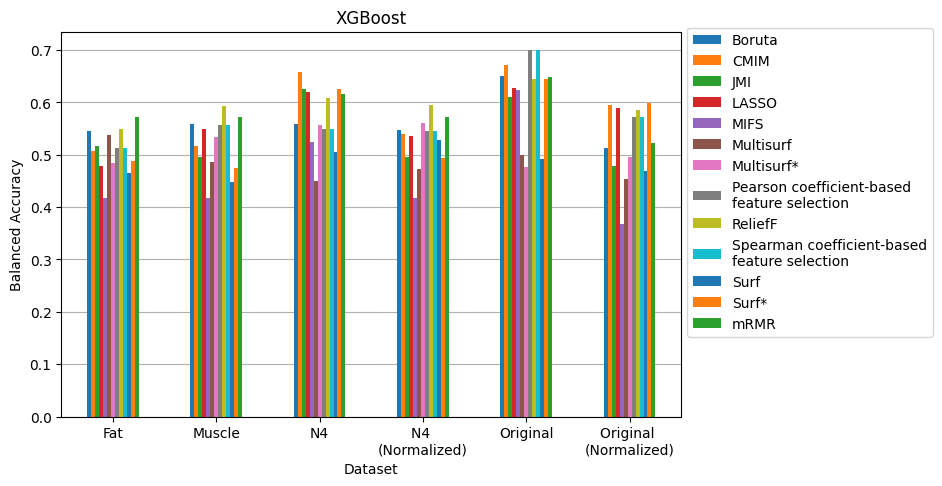

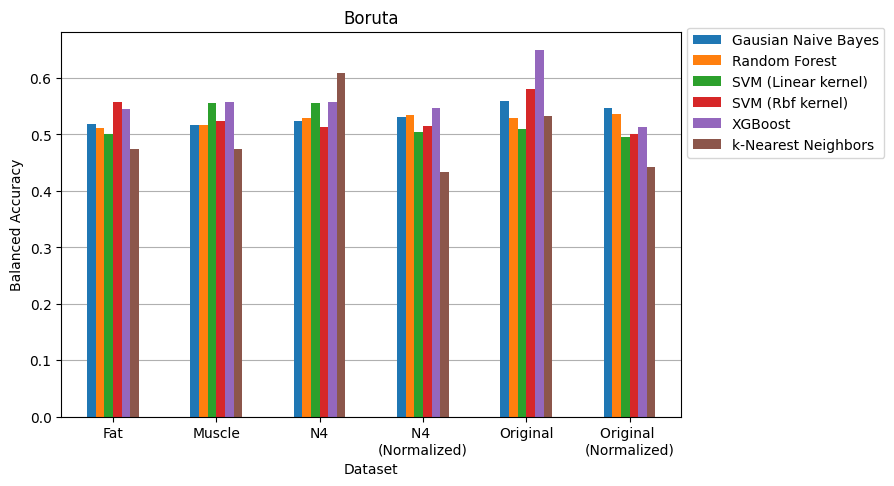

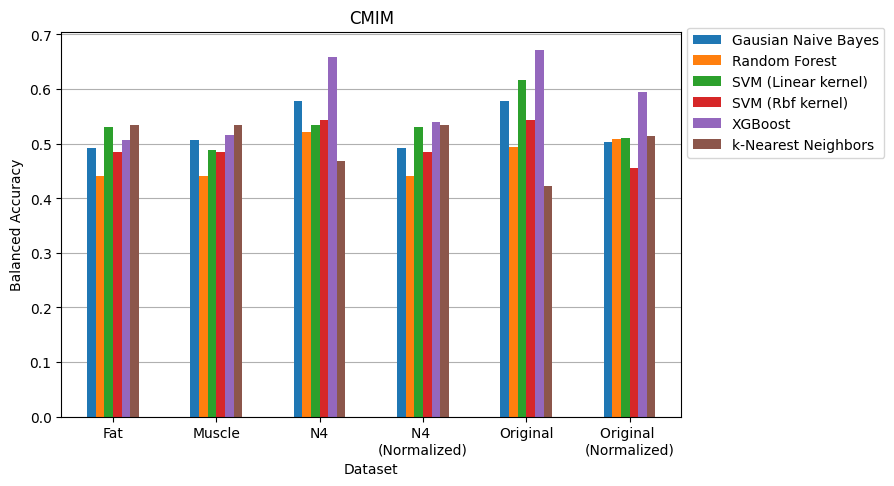

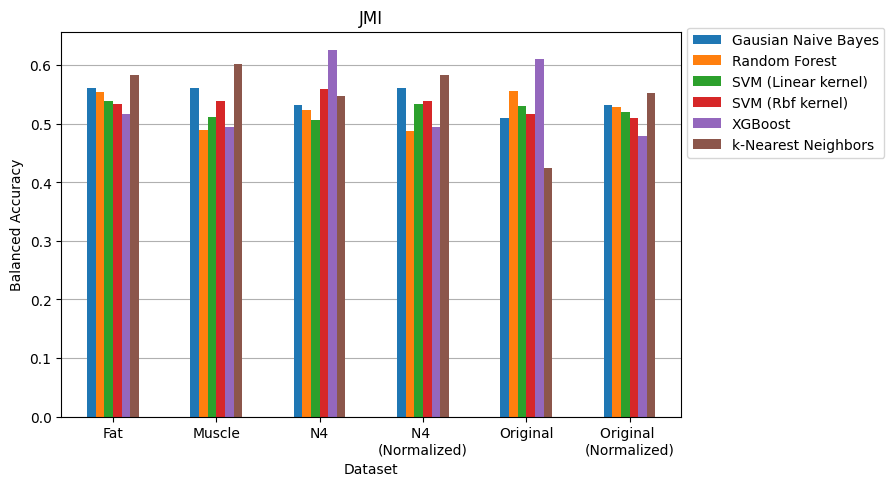

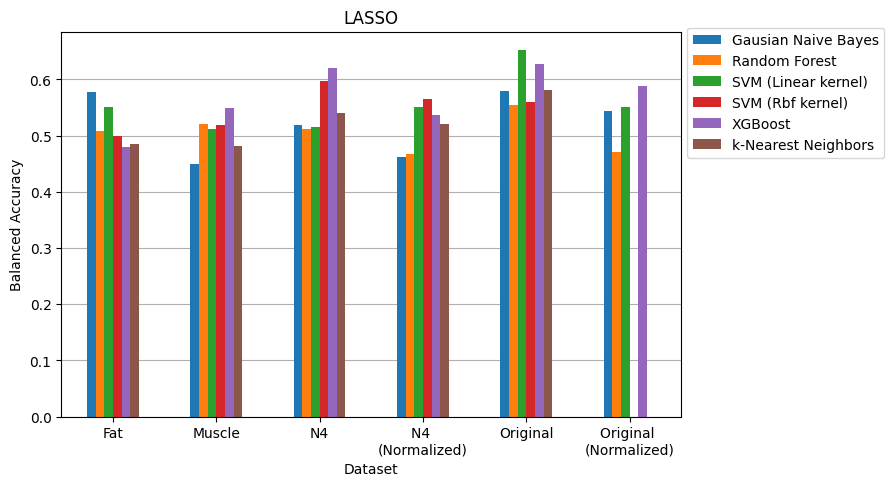

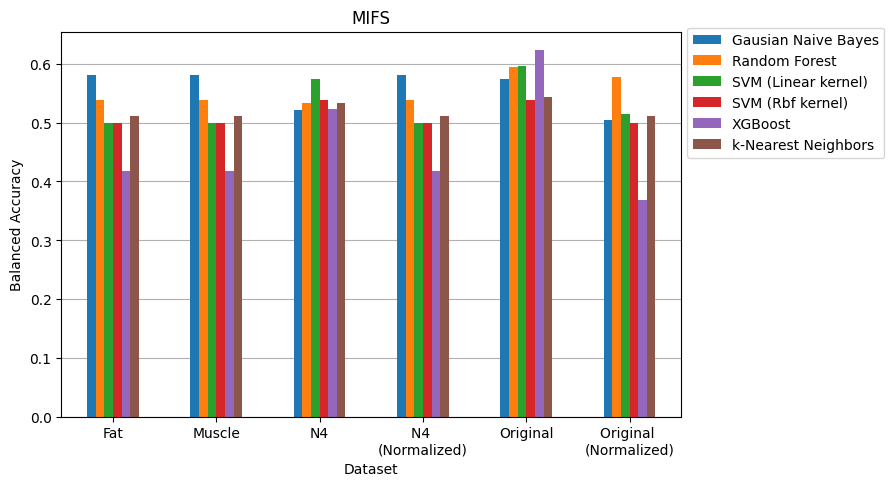

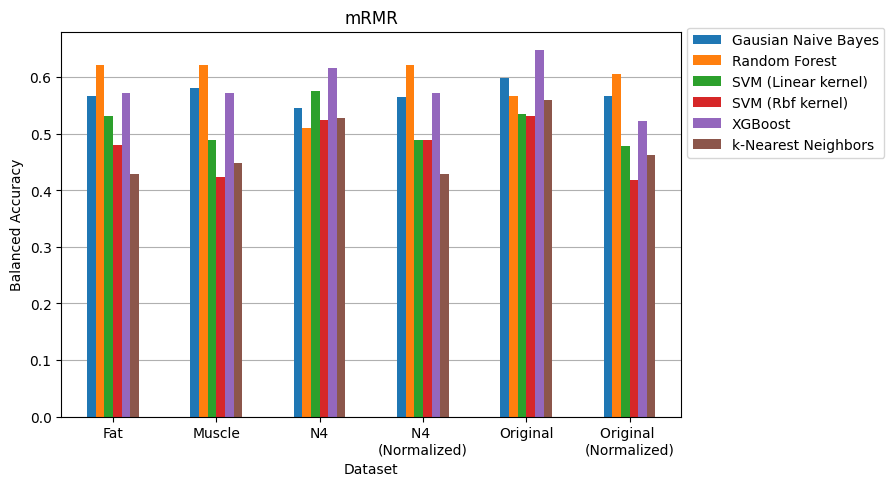

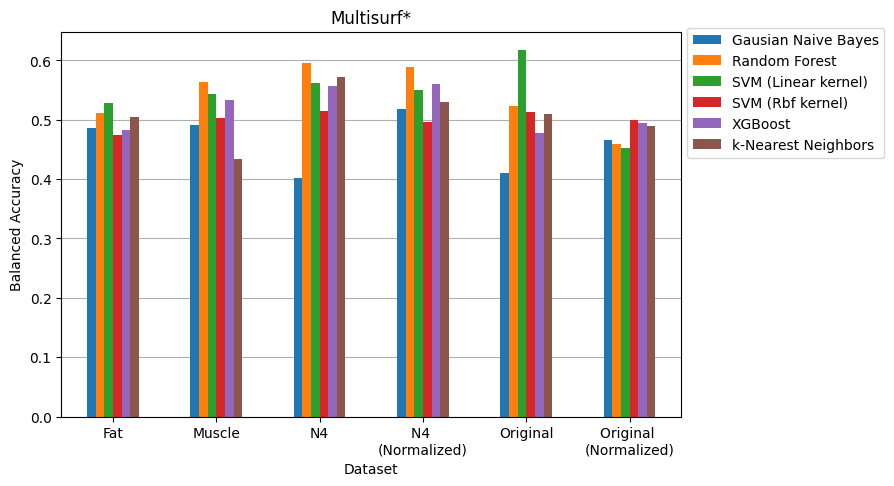

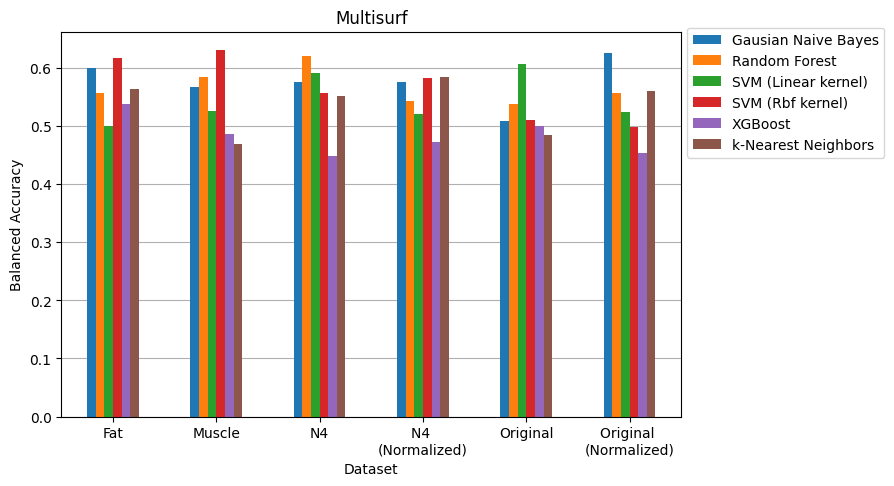

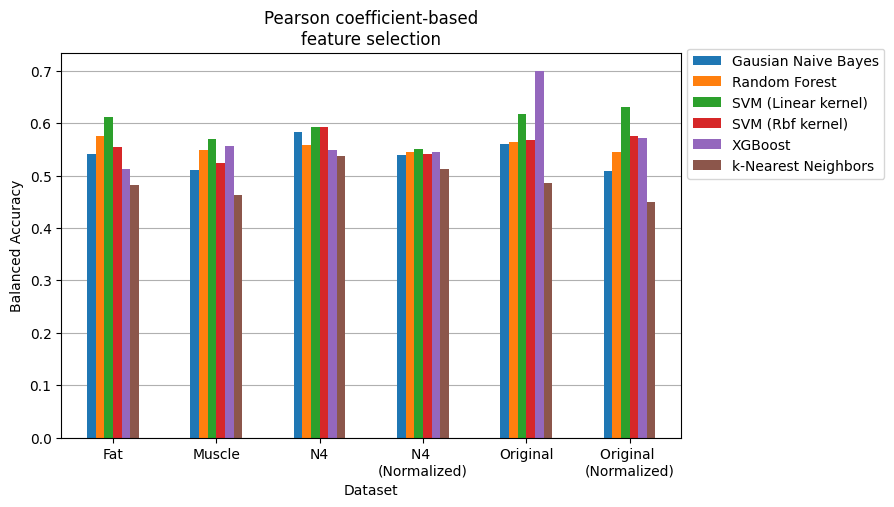

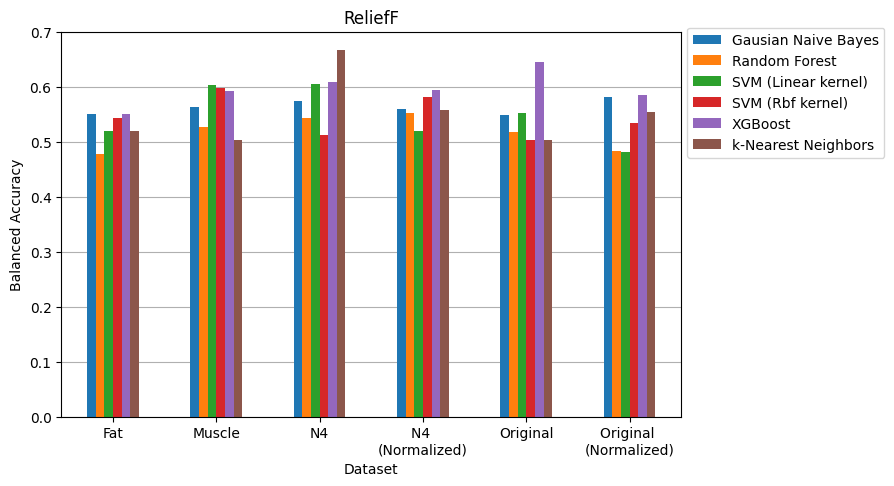

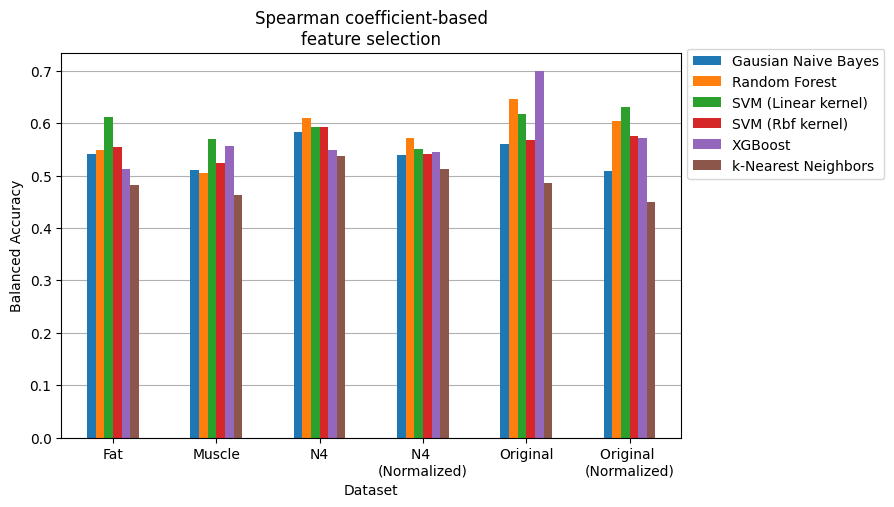

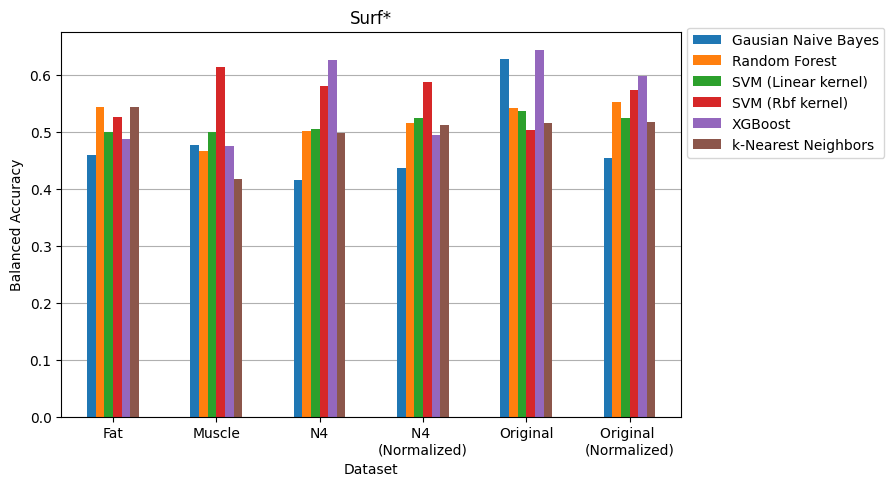

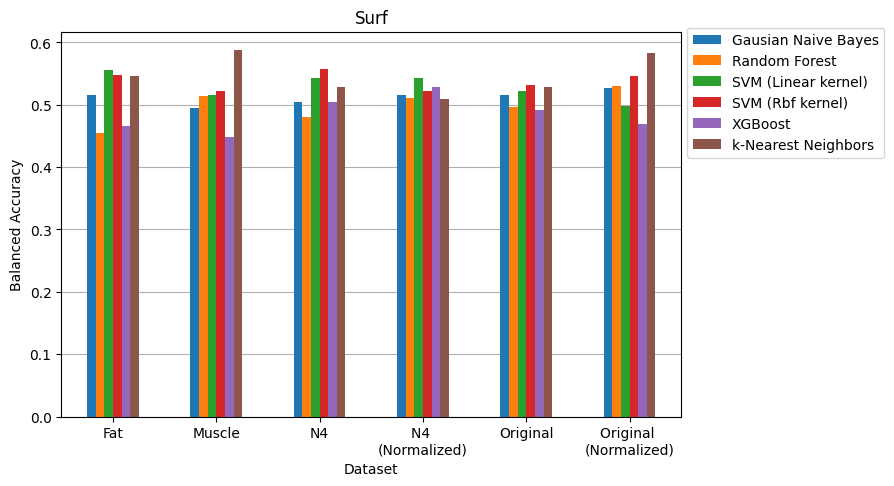

In [20]:
for c in classifiers:
    plotScoreByClassifier(c)

for m in methods:
    plotScoreByFSMethod(m)

In [21]:
topRows = merged.loc[merged['balanced_accuracy_score'] >= 0.60].copy()
topRows = topRows.sort_values(by=['balanced_accuracy_score',  'fullDatasetName'],ascending=False)

# topRows['fullDatasetName'].unique().tolist()
topRows


,featureSelectionMethodName,classifierName,datasetName,isNormalized,selectedFeaturesNo,selectedThreshold,accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,cohen_kappa_score,TN,FP,FN,TP,fullDatasetName,sensitivity,speficity
59,pearson,xgb,original,False,175,0.85,0.722222,0.700000,0.626866,0.656250,0.600000,0.700000,0.406332,44,11,14,21,original,0.600000,0.800000
77,spearman,xgb,original,False,175,0.85,0.722222,0.700000,0.626866,0.656250,0.600000,0.700000,0.406332,44,11,14,21,original,0.600000,0.800000
11,cmim,xgb,original,False,73,0.00,0.700000,0.671851,0.584615,0.678571,0.513514,0.671851,0.356803,44,9,18,19,original,0.513514,0.830189
239,relieff,knn,n4,False,68,0.00,0.722222,0.667017,0.545455,0.714286,0.441176,0.667017,0.361158,50,6,19,15,n4,0.441176,0.892857
189,cmim,xgb,n4,False,13,0.00,0.688889,0.658338,0.562500,0.666667,0.486486,0.658338,0.330144,44,9,19,18,n4,0.486486,0.830189
21,lasso,svm-linear,original,False,55,0.00,0.677778,0.652500,0.539683,0.739130,0.425000,0.652500,0.318538,44,6,23,17,original,0.425000,0.880000
5,boruta,xgb,original,False,96,0.00,0.677778,0.649920,0.553846,0.562500,0.545455,0.649920,0.301766,43,14,15,18,original,0.545455,0.754386
35,mrmr,xgb,original,False,68,0.00,0.666667,0.648084,0.545455,0.720000,0.439024,0.648084,0.305913,42,7,23,18,original,0.439024,0.857143
74,spearman,rf,original,False,259,0.90,0.688889,0.646753,0.533333,0.640000,0.457143,0.646753,0.309589,46,9,19,16,original,0.457143,0.836364
65,relieff,xgb,original,False,83,0.00,0.666667,0.644231,0.558824,0.633333,0.500000,0.644231,0.296875,41,11,19,19,original,0.500000,0.788462


In [22]:
## Get unique for each column

print(topRows['featureSelectionMethodName'].unique().tolist())
print(topRows['classifierName'].unique().tolist())


['pearson', 'spearman', 'cmim', 'relieff', 'lasso', 'boruta', 'mrmr', 'surfstar', 'multisurf', 'jmi', 'mifs', 'multisurfstar']
['xgb', 'knn', 'svm-linear', 'rf', 'svm-rbf', 'gnb']


In [23]:
idxs = topRows.groupby('fullDatasetName')['balanced_accuracy_score'].transform(max) == topRows['balanced_accuracy_score']
df = topRows[idxs].reset_index()

df = df[['fullDatasetName', 'featureSelectionMethodName', 'classifierName', 'balanced_accuracy_score', 'selectedFeaturesNo', 'selectedThreshold']]
df

# from pandas.plotting import table
# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, df, rowLabels=None)  # where df is your data frame
# plt.savefig('test.png', bbox_inches='tight')


,fullDatasetName,featureSelectionMethodName,classifierName,balanced_accuracy_score,selectedFeaturesNo,selectedThreshold
0,original,pearson,xgb,0.700000,175,0.85
1,original,spearman,xgb,0.700000,175,0.85
2,n4,relieff,knn,0.667017,68,0.00
3,original_norm,pearson,svm-linear,0.631169,143,0.70
4,original_norm,spearman,svm-linear,0.631169,143,0.70
5,muscle,multisurf,svm-rbf,0.630927,18,0.00
6,n4_norm,mrmr,rf,0.621651,23,0.00
7,fat,mrmr,rf,0.621651,23,0.00


In [24]:
p = origNormDataset.sort_values(by='balanced_accuracy_score', ascending=False)
# p.loc[(p['featureSelectionMethodName'] == 'spearman') | (p['featureSelectionMethodName'] == 'pearson') ]
p

,featureSelectionMethodName,classifierName,datasetName,isNormalized,selectedFeaturesNo,selectedThreshold,accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,cohen_kappa_score,TN,FP,FN,TP
55,pearson,svm-linear,original,True,143,0.7,0.644444,0.631169,0.555556,0.540541,0.571429,0.631169,0.259640,38,17,15,20
73,spearman,svm-linear,original,True,143,0.7,0.644444,0.631169,0.555556,0.540541,0.571429,0.631169,0.259640,38,17,15,20
40,multisurf,gnb,original,True,13,0.0,0.655556,0.625000,0.507937,0.484848,0.533333,0.625000,0.243902,43,17,14,16
30,mrmr,rf,original,True,23,0.0,0.633333,0.605522,0.492308,0.470588,0.516129,0.605522,0.206307,41,18,15,16
72,spearman,rf,original,True,198,0.8,0.655556,0.603896,0.456140,0.590909,0.371429,0.603896,0.222841,46,9,22,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,pearson-itmo,svm-linear,original,True,98,0.0,0.444444,0.425926,0.324324,0.315789,0.333333,0.425926,-0.146789,28,26,24,12
69,spearman-itmo,xgb,original,True,8,0.0,0.477778,0.419720,0.229508,0.241379,0.218750,0.419720,-0.164007,36,22,25,7
32,mrmr,svm-rbf,original,True,68,0.0,0.466667,0.418016,0.142857,0.222222,0.105263,0.418016,-0.176471,38,14,34,4
65,spearman-itmo,knn,original,True,63,0.0,0.455556,0.409483,0.246154,0.242424,0.250000,0.409483,-0.179775,33,25,24,8


### Analyse Hybrid analysis results

In [25]:
hybridResultsPath = Path('./data/results/hybrid_results/rbest/')
rbest = []
for resultPath in hybridResultsPath.glob('*'):
    resultName = resultPath.name.replace('hybrid_optimals_', '').replace('.json', '')
    data = json.load(open(resultPath, 'r'))
    print(f"Bal. acc.: {data['balanced_accuracy']} - {resultName.replace('_', ' ').title()}.")
    [data['fsMethod1'], data['fsMethod2'], data['classifier']] = data['name'].split('/')
    [data['optimalThreshold'], data['optimalFeatureNo']] = data['params']
    data['datasetName'] = resultName.replace(f"{data['fsMethod1']}_", '').replace(f"{data['fsMethod1']}_", '')
    if 'pearson' in data['datasetName'] or 'spearman' in data['datasetName']:
        data['datasetName'] = 'original'
    if 'norm' in data['datasetName'] and 'n4' not in data['datasetName']:
        data['datasetName'] = 'original norm'
    if 'norm' in data['datasetName'] and 'n4' in data['datasetName']:
        data['datasetName'] = 'n4 norm'
    data['datasetName'] = data['datasetName'].replace('norm', '\n(Normalized)').title()
    
    del data['name']
    del data['params']
    rbest.append(data)

rbest = pd.DataFrame(rbest)    

Bal. acc.: 0.6181818181818182 - Pearson.
Bal. acc.: 0.5272727272727272 - Pearson Fat.
Bal. acc.: 0.5844155844155844 - Pearson Muscle.
Bal. acc.: 0.5961038961038961 - Pearson N4.
Bal. acc.: 0.5389610389610389 - Pearson N4 Norm.
Bal. acc.: 0.5493506493506494 - Pearson Norm.
Bal. acc.: 0.6181818181818182 - Spearman.
Bal. acc.: 0.5454545454545454 - Spearman Fat.
Bal. acc.: 0.5844155844155844 - Spearman Muscle.
Bal. acc.: 0.5961038961038961 - Spearman N4.
Bal. acc.: 0.6077922077922078 - Spearman N4 Norm.
Bal. acc.: 0.5493506493506494 - Spearman Norm.


In [26]:
hybridResultsPath = Path('./data/results/hybrid_results/rbest_cv/')
rbestCV = []
for resultPath in hybridResultsPath.glob('*'):
    resultName = resultPath.name.replace('hybrid_optimals_', '').replace('.json', '')
    data = json.load(open(resultPath, 'r'))
    print(f"Bal. acc.: {data['balanced_accuracy']} - {resultName.replace('_', ' ').title()}.")
    [data['fsMethod1'], data['fsMethod2'], data['classifier']] = data['name'].split('/')
    [data['optimalThreshold'], data['optimalFeatureNo']] = data['params']
    data['datasetName'] = resultName.replace(f"{data['fsMethod1']}_", '').replace(f"{data['fsMethod1']}_", '')
    if 'pearson' in data['datasetName'] or 'spearman' in data['datasetName']:
        data['datasetName'] = 'original'
    if 'norm' in data['datasetName'] and 'n4' not in data['datasetName']:
        data['datasetName'] = 'original norm'
    if 'norm' in data['datasetName'] and 'n4' in data['datasetName']:
        data['datasetName'] = 'n4 norm'
    data['datasetName'] = data['datasetName'].replace('norm', '\n(Normalized)').title()
        
    del data['name']
    del data['params']
    rbestCV.append(data)

rbestCV = pd.DataFrame(rbestCV)   

Bal. acc.: 0.6636363636363636 - Pearson.
Bal. acc.: 0.5064935064935066 - Pearson Fat.
Bal. acc.: 0.5883116883116883 - Pearson Muscle.
Bal. acc.: 0.5402597402597402 - Pearson N4.
Bal. acc.: 0.5532467532467533 - Pearson N4 Norm.
Bal. acc.: 0.5701298701298702 - Pearson Norm.
Bal. acc.: 0.6636363636363636 - Spearman.
Bal. acc.: 0.5532467532467533 - Spearman Fat.
Bal. acc.: 0.5883116883116883 - Spearman Muscle.
Bal. acc.: 0.5402597402597402 - Spearman N4.
Bal. acc.: 0.5012987012987014 - Spearman N4 Norm.
Bal. acc.: 0.5701298701298702 - Spearman Norm.


In [27]:
hybridResultsPath = Path('./data/results/hybrid_results/r0.95/')
r095 = []
for resultPath in hybridResultsPath.glob('*'):
    resultName = resultPath.name.replace('hybrid_optimals_', '').replace('.json', '')
    data = json.load(open(resultPath, 'r'))
    print(f"Bal. acc.: {data['balanced_accuracy']} - {resultName.replace('_', ' ').title()}.")
    [data['fsMethod1'], data['fsMethod2'], data['classifier']] = data['name'].split('/')
    [data['optimalThreshold'], data['optimalFeatureNo']] = data['params']
    data['datasetName'] = resultName.replace(f"{data['fsMethod1']}_", '').replace('_', ' ')
    if 'pearson' in data['datasetName'] or 'spearman' in data['datasetName']:
        data['datasetName'] = 'original'
    if 'norm' in data['datasetName'] and 'n4' not in data['datasetName']:
        data['datasetName'] = 'original norm'
    if 'norm' in data['datasetName'] and 'n4' in data['datasetName']:
        data['datasetName'] = 'n4 norm'
    data['datasetName'] = data['datasetName'].replace('norm', '\n(Normalized)').title()
    
    del data['name']
    del data['params']
    r095.append(data)

r095 = pd.DataFrame(r095)

Bal. acc.: 0.5636363636363637 - Pearson.
Bal. acc.: 0.5428571428571428 - Pearson Fat.
Bal. acc.: 0.612987012987013 - Pearson Muscle.
Bal. acc.: 0.5961038961038961 - Pearson N4.
Bal. acc.: 0.5194805194805194 - Pearson N4 Norm.
Bal. acc.: 0.6363636363636364 - Pearson Norm.
Bal. acc.: 0.5636363636363637 - Spearman.
Bal. acc.: 0.5818181818181818 - Spearman Fat.
Bal. acc.: 0.612987012987013 - Spearman Muscle.
Bal. acc.: 0.5961038961038961 - Spearman N4.
Bal. acc.: 0.5298701298701298 - Spearman N4 Norm.
Bal. acc.: 0.6363636363636364 - Spearman Norm.


In [28]:
hybridResultsPath = Path('./data/results/hybrid_results/r0.95_cv/')
r095CV = []
for resultPath in hybridResultsPath.glob('*'):
    resultName = resultPath.name.replace('hybrid_optimals_', '').replace('.json', '')
    data = json.load(open(resultPath, 'r'))
    print(f"Bal. acc.: {data['balanced_accuracy']} - {resultName.replace('_', ' ').title()}.")
    [data['fsMethod1'], data['fsMethod2'], data['classifier']] = data['name'].split('/')
    [data['optimalThreshold'], data['optimalFeatureNo']] = data['params']
    data['datasetName'] = resultName.replace(f"{data['fsMethod1']}_", '').replace('_', ' ')
    if 'pearson' in data['datasetName'] or 'spearman' in data['datasetName']:
        data['datasetName'] = 'original'
    if 'norm' in data['datasetName'] and 'n4' not in data['datasetName']:
        data['datasetName'] = 'original norm'
    if 'norm' in data['datasetName'] and 'n4' in data['datasetName']:
        data['datasetName'] = 'n4 norm'
    data['datasetName'] = data['datasetName'].replace('norm', '\n(Normalized)').title()
    
    del data['name']
    del data['params']
    r095CV.append(data)

r095CV = pd.DataFrame(r095CV)

Bal. acc.: 0.5753246753246752 - Pearson.
Bal. acc.: 0.5285714285714286 - Pearson Fat.
Bal. acc.: 0.535064935064935 - Pearson Muscle.
Bal. acc.: 0.5948051948051949 - Pearson N4.
Bal. acc.: 0.5831168831168831 - Pearson N4 Norm.
Bal. acc.: 0.5441558441558442 - Pearson Norm.
Bal. acc.: 0.5753246753246752 - Spearman.
Bal. acc.: 0.5337662337662338 - Spearman Fat.
Bal. acc.: 0.535064935064935 - Spearman Muscle.
Bal. acc.: 0.5948051948051949 - Spearman N4.
Bal. acc.: 0.5597402597402598 - Spearman N4 Norm.
Bal. acc.: 0.5441558441558442 - Spearman Norm.


In [29]:
rbest = rbest.loc[rbest['fsMethod1'] == 'pearson']
rbestCV = rbestCV.loc[rbestCV['fsMethod1'] == 'pearson']
r095 = r095.loc[r095['fsMethod1'] == 'pearson']
r095CV = r095CV.loc[r095CV['fsMethod1'] == 'pearson']


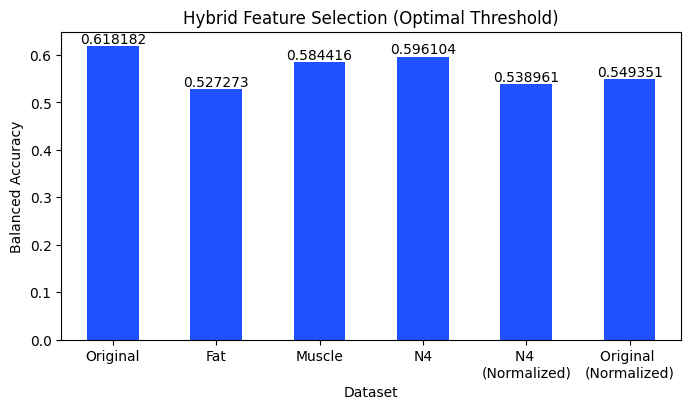

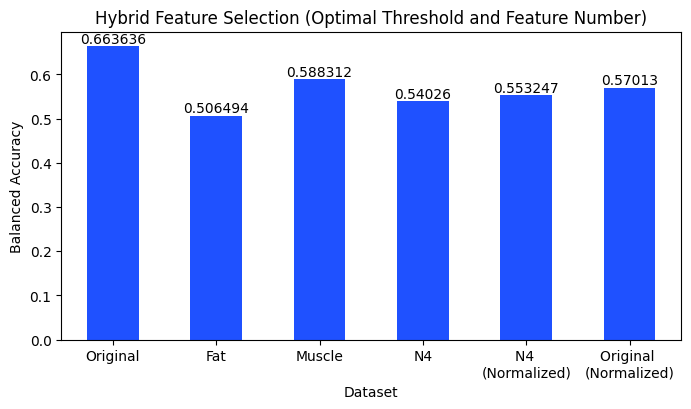

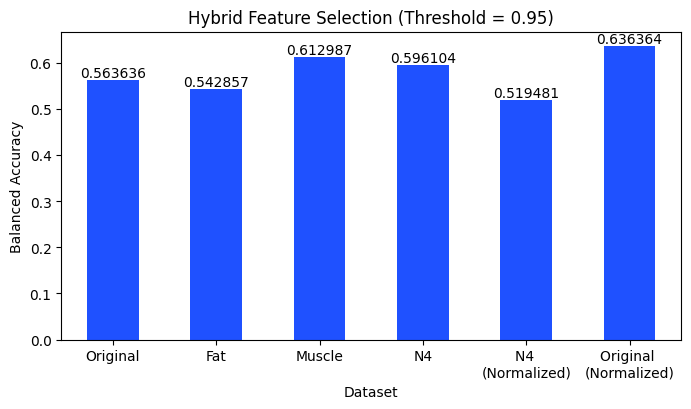

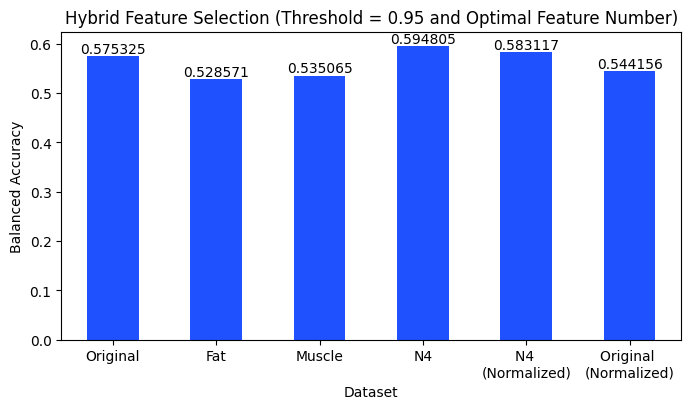

In [30]:
ax = rbest.plot.bar(x="datasetName", y="balanced_accuracy", color='#1F51FF', figsize=(8, 4), rot=0, legend=False, title='Hybrid Feature Selection (Optimal Threshold)', xlabel='Dataset', ylabel="Balanced Accuracy")
ax.bar_label(ax.containers[0])
ax.figure.savefig('data/results/hybrid_results/hybrid_optimal_threshold.png')

ax = rbestCV.plot.bar(x="datasetName", y="balanced_accuracy", color='#1F51FF', figsize=(8, 4), rot=0, legend=False, title='Hybrid Feature Selection (Optimal Threshold and Feature Number)', xlabel='Dataset', ylabel="Balanced Accuracy")
ax.bar_label(ax.containers[0])
ax.figure.savefig('data/results/hybrid_results/hybrid_optimal_threshold_and_feature_no.png')

ax = r095.plot.bar(x="datasetName", y="balanced_accuracy", color='#1F51FF', figsize=(8, 4), rot=0, legend=False, title='Hybrid Feature Selection (Threshold = 0.95)', xlabel='Dataset', ylabel="Balanced Accuracy")
ax.bar_label(ax.containers[0])
ax.figure.savefig('data/results/hybrid_results/hybrid_095_threshold.png')

ax = r095CV.plot.bar(x="datasetName", y="balanced_accuracy", color='#1F51FF', figsize=(8, 4), rot=0, legend=False, title='Hybrid Feature Selection (Threshold = 0.95 and Optimal Feature Number)', xlabel='Dataset', ylabel="Balanced Accuracy")
ax.bar_label(ax.containers[0])
ax.figure.savefig('data/results/hybrid_results/hybrid_095_threshold_optimal_feature_no.png')

In [31]:
hybridResultsPath = Path('./data/results/hybrid_results/rbest2/')
rbest2 = []
for resultPath in hybridResultsPath.glob('*'):
    resultName = resultPath.name.replace('hybrid_optimals_', '').replace('.json', '')
    data = json.load(open(resultPath, 'r'))
    print(f"Bal. acc.: {data['balanced_accuracy']} - {resultName.replace('_', ' ').title()}.")
    [data['fsMethod1'], data['fsMethod2'], data['classifier']] = data['name'].split('/')
    [data['optimalThreshold'], data['optimalFeatureNo']] = data['params']
    data['datasetName'] = resultName.replace(f"{data['fsMethod1']}_", '').replace(f"{data['fsMethod1']}_", '')
    if 'pearson' in data['datasetName'] or 'spearman' in data['datasetName']:
        data['datasetName'] = 'original'
    if 'norm' in data['datasetName'] and 'n4' not in data['datasetName']:
        data['datasetName'] = 'original norm'
    if 'norm' in data['datasetName'] and 'n4' in data['datasetName']:
        data['datasetName'] = 'n4 norm'
    data['datasetName'] = data['datasetName'].replace('norm', '\n(Normalized)').title()
        
    del data['name']
    del data['params']
    rbest2.append(data)

rbest2 = pd.DataFrame(rbest2)

hybridResultsPath = Path('./data/results/hybrid_results/rbest_cv2/')
rbestCV2 = []
for resultPath in hybridResultsPath.glob('*'):
    resultName = resultPath.name.replace('hybrid_optimals_cv_', '').replace('.json', '')
    data = json.load(open(resultPath, 'r'))
    print(f"Bal. acc.: {data['balanced_accuracy']} - {resultName.replace('_', ' ').title()}.")
    [data['fsMethod1'], data['fsMethod2'], data['classifier']] = data['name'].split('/')
    [data['optimalThreshold'], data['optimalFeatureNo']] = data['params']
    data['datasetName'] = resultName.replace(f"{data['fsMethod1']}_", '').replace(f"{data['fsMethod1']}_", '')
    if 'pearson' in data['datasetName'] or 'spearman' in data['datasetName']:
        data['datasetName'] = 'original'
    if 'norm' in data['datasetName'] and 'n4' not in data['datasetName']:
        data['datasetName'] = 'original norm'
    if 'norm' in data['datasetName'] and 'n4' in data['datasetName']:
        data['datasetName'] = 'n4 norm'
    data['datasetName'] = data['datasetName'].replace('norm', '\n(Normalized)').title()
        
    del data['name']
    del data['params']
    rbestCV2.append(data)

rbestCV2 = pd.DataFrame(rbestCV2)

rbest2 = rbest2.loc[rbest2['fsMethod1'] == 'pearson']
rbestCV2 = rbestCV2.loc[rbestCV2['fsMethod1'] == 'pearson']

ax = rbest2.plot.bar(x="datasetName", y="balanced_accuracy", color='#1F51FF', figsize=(8, 4), rot=0, legend=False, title='Hybrid Feature Selection (Optimal Threshold)', xlabel='Dataset', ylabel="Balanced Accuracy")
ax.bar_label(ax.containers[0])
ax.figure.savefig('data/results/hybrid_results/hybrid_optimal_threshold_2.png')

ax = rbestCV2.plot.bar(x="datasetName", y="balanced_accuracy", color='#1F51FF', figsize=(8, 4), rot=0, legend=False, title='Hybrid Feature Selection (Optimal Threshold and Feature Number)', xlabel='Dataset', ylabel="Balanced Accuracy")
ax.bar_label(ax.containers[0])
ax.figure.savefig('data/results/hybrid_results/hybrid_optimal_threshold_and_feature_no_2.png')

Bal. acc.: 0.6181818181818182 - Pearson.
Bal. acc.: 0.5727272727272728 - Pearson Fat.
Bal. acc.: 0.5844155844155844 - Pearson Muscle.
Bal. acc.: 0.5961038961038961 - Pearson N4.
Bal. acc.: 0.5857142857142856 - Pearson N4 Norm.
Bal. acc.: 0.5493506493506494 - Pearson Norm.
Bal. acc.: 0.6181818181818182 - Spearman.
Bal. acc.: 0.5116883116883116 - Spearman Fat.
Bal. acc.: 0.5844155844155844 - Spearman Muscle.
Bal. acc.: 0.5961038961038961 - Spearman N4.
Bal. acc.: 0.5285714285714286 - Spearman N4 Norm.
Bal. acc.: 0.5493506493506494 - Spearman Norm.
Bal. acc.: 0.6077922077922078 - Pearson.
Bal. acc.: 0.5428571428571429 - Pearson Fat.
Bal. acc.: 0.5974025974025974 - Pearson Muscle.
Bal. acc.: 0.5298701298701298 - Pearson N4.
Bal. acc.: 0.4922077922077922 - Pearson N4 Norm.
Bal. acc.: 0.574025974025974 - Pearson Norm.
Bal. acc.: 0.6077922077922078 - Spearman.
Bal. acc.: 0.6038961038961039 - Spearman Fat.
Bal. acc.: 0.5974025974025974 - Spearman Muscle.
Bal. acc.: 0.5298701298701298 - Spearma

PermissionError: [Errno 13] Permission denied: 'data\\results\\hybrid_results\\rbest_cv2\\rbest2'

Bal. acc.: 0.6181818181818182 - Pearson.
Bal. acc.: 0.5402597402597402 - Pearson Fat.
Bal. acc.: 0.5844155844155844 - Pearson Muscle.
Bal. acc.: 0.5961038961038961 - Pearson N4.
Bal. acc.: 0.5103896103896104 - Pearson N4 Norm.
Bal. acc.: 0.5493506493506494 - Pearson Norm.
Bal. acc.: 0.6181818181818182 - Spearman.
Bal. acc.: 0.5688311688311688 - Spearman Fat.
Bal. acc.: 0.5844155844155844 - Spearman Muscle.
Bal. acc.: 0.5961038961038961 - Spearman N4.
Bal. acc.: 0.5623376623376624 - Spearman N4 Norm.
Bal. acc.: 0.5493506493506494 - Spearman Norm.
Bal. acc.: 1.0 - Pearson.
Bal. acc.: 1.0 - Pearson Fat.
Bal. acc.: 0.7584415584415585 - Pearson Muscle.
Bal. acc.: 0.7454545454545454 - Pearson N4.
Bal. acc.: 1.0 - Pearson N4 Norm.
Bal. acc.: 0.9766233766233766 - Pearson Norm.
Bal. acc.: 1.0 - Spearman.
Bal. acc.: 0.9857142857142858 - Spearman Fat.
Bal. acc.: 0.7584415584415585 - Spearman Muscle.
Bal. acc.: 0.7454545454545454 - Spearman N4.
Bal. acc.: 0.9766233766233766 - Spearman N4 Norm.
Bal

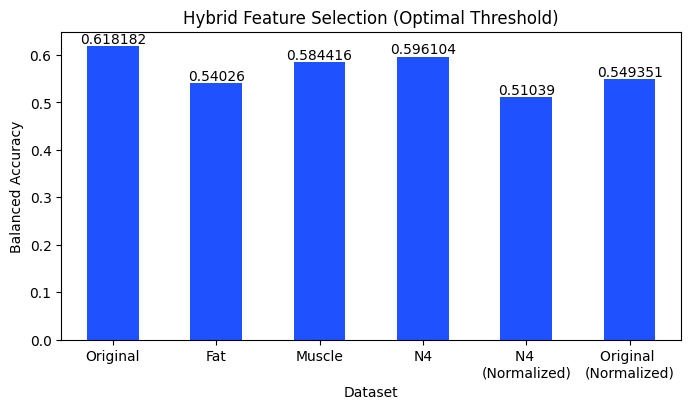

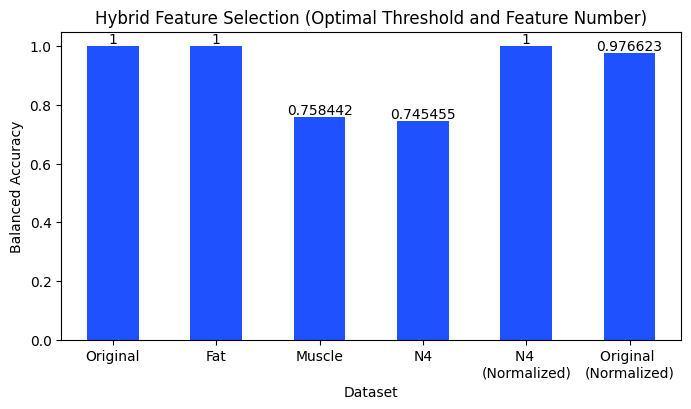

In [ ]:
hybridResultsPath = Path('./data/results/hybrid_results/rbest3/')
rbest2 = []
for resultPath in hybridResultsPath.glob('*'):
    resultName = resultPath.name.replace('hybrid_optimals_', '').replace('.json', '')
    data = json.load(open(resultPath, 'r'))
    print(f"Bal. acc.: {data['balanced_accuracy']} - {resultName.replace('_', ' ').title()}.")
    [data['fsMethod1'], data['fsMethod2'], data['classifier']] = data['name'].split('/')
    [data['optimalThreshold'], data['optimalFeatureNo']] = data['params']
    data['datasetName'] = resultName.replace(f"{data['fsMethod1']}_", '').replace(f"{data['fsMethod1']}_", '')
    if 'pearson' in data['datasetName'] or 'spearman' in data['datasetName']:
        data['datasetName'] = 'original'
    if 'norm' in data['datasetName'] and 'n4' not in data['datasetName']:
        data['datasetName'] = 'original norm'
    if 'norm' in data['datasetName'] and 'n4' in data['datasetName']:
        data['datasetName'] = 'n4 norm'
    data['datasetName'] = data['datasetName'].replace('norm', '\n(Normalized)').title()
        
    del data['name']
    del data['params']
    rbest2.append(data)

rbest2 = pd.DataFrame(rbest2)

hybridResultsPath = Path('./data/results/hybrid_results/rbest_cv3/')
rbestCV2 = []
for resultPath in hybridResultsPath.glob('*'):
    resultName = resultPath.name.replace('hybrid_optimals_cv_', '').replace('.json', '')
    data = json.load(open(resultPath, 'r'))
    print(f"Bal. acc.: {data['balanced_accuracy']} - {resultName.replace('_', ' ').title()}.")
    [data['fsMethod1'], data['fsMethod2'], data['classifier']] = data['name'].split('/')
    [data['optimalThreshold'], data['optimalFeatureNo']] = data['params']
    data['datasetName'] = resultName.replace(f"{data['fsMethod1']}_", '').replace(f"{data['fsMethod1']}_", '')
    if 'pearson' in data['datasetName'] or 'spearman' in data['datasetName']:
        data['datasetName'] = 'original'
    if 'norm' in data['datasetName'] and 'n4' not in data['datasetName']:
        data['datasetName'] = 'original norm'
    if 'norm' in data['datasetName'] and 'n4' in data['datasetName']:
        data['datasetName'] = 'n4 norm'
    data['datasetName'] = data['datasetName'].replace('norm', '\n(Normalized)').title()
        
    del data['name']
    del data['params']
    rbestCV2.append(data)

rbestCV2 = pd.DataFrame(rbestCV2)

rbest2 = rbest2.loc[rbest2['fsMethod1'] == 'pearson']
rbestCV2 = rbestCV2.loc[rbestCV2['fsMethod1'] == 'pearson']

ax = rbest2.plot.bar(x="datasetName", y="balanced_accuracy", color='#1F51FF', figsize=(8, 4), rot=0, legend=False, title='Hybrid Feature Selection (Optimal Threshold)', xlabel='Dataset', ylabel="Balanced Accuracy")
ax.bar_label(ax.containers[0])
ax.figure.savefig('data/results/hybrid_results/hybrid_optimal_threshold_3.png')

ax = rbestCV2.plot.bar(x="datasetName", y="balanced_accuracy", color='#1F51FF', figsize=(8, 4), rot=0, legend=False, title='Hybrid Feature Selection (Optimal Threshold and Feature Number)', xlabel='Dataset', ylabel="Balanced Accuracy")
ax.bar_label(ax.containers[0])
ax.figure.savefig('data/results/hybrid_results/hybrid_optimal_threshold_and_feature_no_3.png')